In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('bmh')

import copy

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

<h3>Loading CSV data in dataframe</h3>

Drop movie_imdb_link because it will not have any impact on the ratings

The genres column contains the genres in which the movie can fall in. We are splitting the values so that we have an array of genres which becomes easier to handle downstream. Same with the feature plot_keywords

In [2]:
df = pd.read_csv('movie_review_data.csv').drop(['movie_imdb_link'], axis=1)
df['genres'] = df['genres'].apply(lambda x: x.split("|"))
df['plot_keywords'] = df['plot_keywords'].fillna("").apply(lambda x: x.split("|"))

<h1>Type of features</h1>

<h3>Numerical Features</h3>
<p> Features which has a data type of integer and float </p>
We will use these directly in the models


In [3]:
numerical_features = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()

<b>Complex Features</b>
<p> Features which has a data type of string object but needs a different encoding mechanism</p> 
<p>Function used for this encoding is <b>category_mean_encoding</b> </p>

We have used mean encoding because the number of actual categories in the features are large

Thus, one-hot encoding will lead to higher dimesnions

Label encoding will add a ranking to the categorical variables which are not inherently ordered.
    
    Steps for mean encoding complex columns
    
    1. Take average imdb_score of each item in complex column of the training data set, Lets call it value_score
    
    2. For each movie take the average of value _score of all values in the complex column
    
    3. Use these scores for transforming the test data as well.
    
We use the training encoding score so that we can encode an individual row of test data


In [4]:
complex_features = ['genres', 'plot_keywords']

#mean encoding plot_keywords and genre column

def category_score(x, scores):
    score = 0
    num_category = 0
    for category in x:
        if category in scores:
            score += scores[category]
            num_category += 1
        
    
    return score/num_category
        

def category_mean_encoding(X_train, X_test, feature):
    new_feature_name = feature + "_encoding"
    category_values = X_train.explode(feature).groupby(feature)['imdb_score'].mean().reset_index().rename(columns={"imdb_score": new_feature_name})
    
    category_encoding_train = X_train.explode(feature).merge(category_values, on=feature, how='left').groupby('movie_title')[new_feature_name].mean().reset_index()
    X_train = X_train.merge(category_encoding_train, on='movie_title', how='left').drop(['imdb_score', feature, 'movie_title'], axis=1)
    
    category_encoding_test = X_test.explode(feature).merge(category_values, on=feature, how='left').groupby('movie_title')[new_feature_name].mean().reset_index()
    X_test = X_test.merge(category_encoding_test, on='movie_title', how='left').drop(['imdb_score', feature, 'movie_title'], axis=1)
    
    return [X_train, X_test]

df[complex_features].sample(2)

,genres,plot_keywords
2367,"[Comedy, Drama, Romance]","[artificial insemination, best friend, new yor..."
2525,"[Biography, Crime, Drama, Thriller]","[criminal, drug lord, gunshot, irish, journalist]"


<h3>Categorical Features</h3>
<p> Features which has a data type of string object which have to encoded </p>
We will use mean encoding as implemented in the function <b>mean_encoding_columns</b>

We have used mean encoding because the number of categories in the features are large.

Thus, one-hot encoding will lead to higher dimesnions

Label encoding will add a ranking to the categorical variables which are not inherently ordered.

    Steps
    
    1. Check if encoding has to been done on all categorical columns at once or one by one
    
    2. Calculate average imdb_score of each category in training date as the encoded value
    
    3. Use these encoded values for transforming the test data as well
    

We use the training encoding score so that we can encode an individual test data
    



In [5]:
categorical_features = df.select_dtypes(include = ['object']).columns.tolist()
categorical_features.append("title_year")
categorical_features.remove('genres')
categorical_features.remove('plot_keywords')

#mean encoding of columns
def mean_encoding_individual_column(X_train, X_test, col):
    if (col == 'genres' or col == 'plot_keywords'):
        genre_scores = category_mean_encoding(X_train, X_test, col)
        X_train = genre_scores[0]
        X_test = genre_scores[1]
    else:
        encoding = pd.DataFrame(X_train.groupby(col)['imdb_score'].mean()).reset_index().rename(columns={"imdb_score": col + "_encoding"})
        X_train = X_train.merge(encoding, on=col, how="left").drop([col, 'imdb_score'], axis=1)
        X_test = X_test.merge(encoding, on=col, how="left").drop([col, 'imdb_score'], axis=1)  
            
    return X_train, X_test
    

#mean encoding of multiple columns at once
def mean_encoding_columns(X_train, X_test, colList):
    if (type(colList) == list):
        for col in colList:

            if (col == 'genres' or col == 'plot_keywords'):
                genre_scores = category_mean_encoding(X_train, X_test, col)
                X_train = genre_scores[0]
                X_test = genre_scores[1]
            else:
                encoding = pd.DataFrame(X_train.groupby(col)['imdb_score'].mean()).reset_index().rename(columns={"imdb_score": col + "_encoding"})
                X_train = X_train.merge(encoding, on=col, how="left").drop([col], axis=1)
                X_test = X_test.merge(encoding, on=col, how="left").drop([col], axis=1)  
    else:
        X_train, X_test = mean_encoding_individual_column(X_train, X_test, colList)

    return X_train, X_test
    

<h1>Missing Values</h1>


In [6]:
df.isnull().sum()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                  0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

## Imputing missing values
We see from the above cell that features `gross` and `budget` has the maximum number of missing values.

Hence we use mean strategy to impute missing values from these columns, in the cross validation pipeline.

For all other columns including encoded columns we replace missing values with 0 in the cross validation pipeline.

<h1>Exploratory Data Analysis</h1>

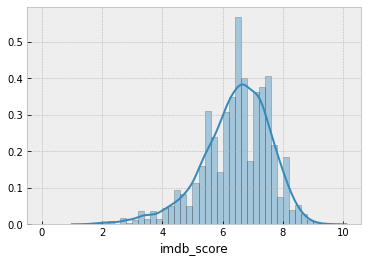

In [7]:
# Frequency distribution of imdb_score
sns.distplot(df['imdb_score'], bins=np.arange(0,10,0.2), hist_kws=dict(ec="k"))

Most of the IMDB scores in our data set falls between 5.5-8. This follows general trend of movie ratings on IMDB. Most great movies are above 8. Majority are rated 6-8, with 7-8 being above average to good movie. Any movie below 6 is below average and thus no much difference really in movies rated 1 to 6.

## Numerical feature plots w.r.t `imdb_score`


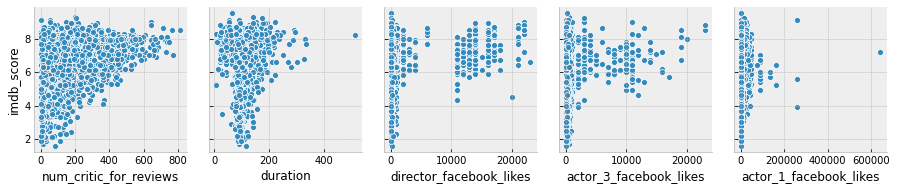

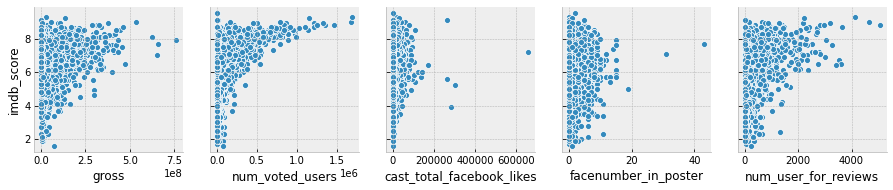

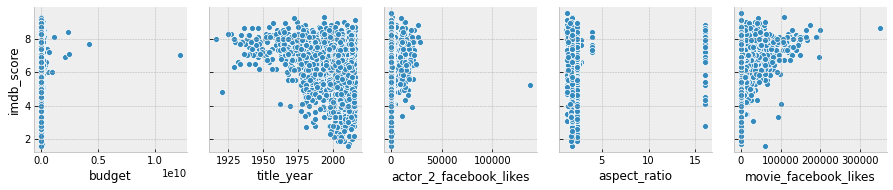

In [8]:
df_num = df.select_dtypes(exclude = ['object']).drop('imdb_score', axis=1)
y = df.select_dtypes(exclude = ['object'])['imdb_score']

df_num_y = pd.concat([df_num, y], axis=1, sort=False, copy=False)

for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num_y,
                x_vars=df_num.columns[i:i+5],
                y_vars=['imdb_score'])

## Numerical features correlation with `imdb_score`

In [9]:
# Correlation of numerical features with imdb_score
X_corr = df_num_y.corr()['imdb_score']
corr_features_ls_sorted = X_corr.sort_values(ascending=False)
corr_features_ls_sorted[1:,]

num_voted_users              0.410965
num_critic_for_reviews       0.305303
num_user_for_reviews         0.292475
duration                     0.261662
movie_facebook_likes         0.247049
gross                        0.198021
director_facebook_likes      0.170802
cast_total_facebook_likes    0.085787
actor_2_facebook_likes       0.083808
actor_1_facebook_likes       0.076099
aspect_ratio                 0.059445
actor_3_facebook_likes       0.052633
budget                       0.030688
facenumber_in_poster        -0.062958
title_year                  -0.209167
Name: imdb_score, dtype: float64

Only `num_voted_users` has a correlation above 0.4 with `imdb_score`.
Rest of the features are not very highly correlated to `imdb_score`

Removing outliers from numerical features and checking if that increases its correlation with `imdb_score`

In [10]:
# Outlier treatment
X = df_num_y.drop('imdb_score', axis=1)
y = df_num_y['imdb_score']

for col in X.columns:
    # Calculating quartiles
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3-Q1
    min_value = Q1-1.5*IQR
    max_value = Q3+1.5*IQR
    
    X[col].loc[X[col] > max_value] = max_value
    X[col].loc[X[col] < min_value] = min_value

df_num_outliered = pd.concat([X, y], axis=1, sort=False, copy=False)
X_corr = df_num_outliered.corr()['imdb_score']
corr_features_ls_sorted = X_corr.sort_values(ascending=False)
corr_features_ls_sorted[1:,]

/Users/abhijeetraj/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


num_voted_users              0.420783
num_user_for_reviews         0.323100
num_critic_for_reviews       0.303667
duration                     0.288349
movie_facebook_likes         0.284241
director_facebook_likes      0.205504
gross                        0.172734
actor_1_facebook_likes       0.142960
cast_total_facebook_likes    0.128713
actor_2_facebook_likes       0.042499
budget                       0.025321
aspect_ratio                 0.001529
actor_3_facebook_likes       0.001190
facenumber_in_poster        -0.075103
title_year                  -0.187683
Name: imdb_score, dtype: float64

Outlier removal doesn't change the correlation much.

So, numerical features are not very much correlated with `imdb_score`, except maybe `num_voted_users` to some extent.

## Numerical feature correlation amongst themselves

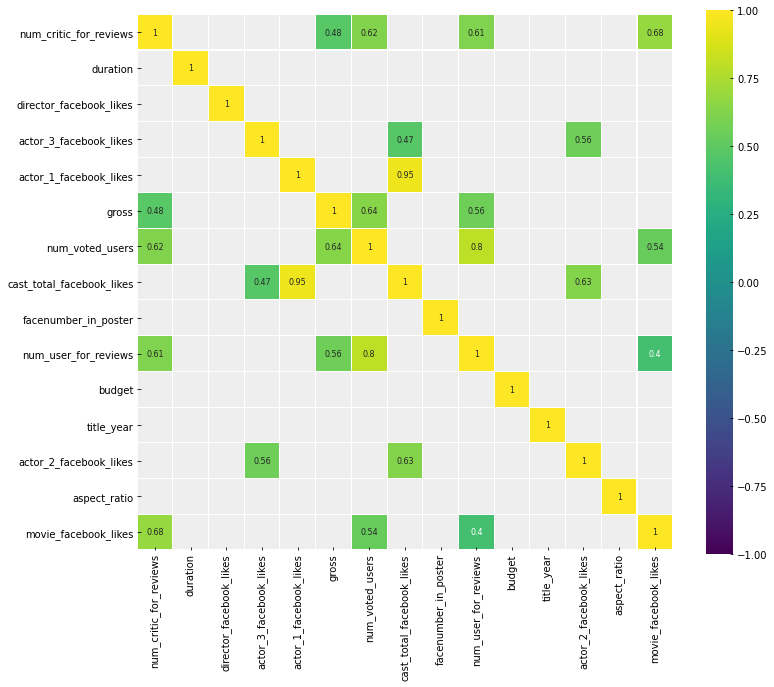

In [11]:
df_num_corr = df_num_y.select_dtypes(exclude = ['object']).drop('imdb_score', axis=1).corr()

plt.figure(figsize=(12, 10))

sns.heatmap(df_num_corr[(df_num_corr >= 0.4) | (df_num_corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

A lot of features looks correlated amongst themselves.

Some of them are easily explainable, for eg.- `num_critic_for_reviews` & `num_voted_users`, `num_user_for_reviews` & `num_voted_users` etc. Reviews will be more, when more users will vote for the movie. Similarly, `cast_total_facebook_likes` & `actor_1_facebook_likes` etc.

Some are less obvious -
    `movie_facebook_likes` & `num_critic_for_reviews` and `movie_facebook_likes` & `num_voted_users`, users who reviewed has higher chances of liking the movie.
    `gross` & `num_voted_users` and `gross` & `num_users_for_reviews`, same as above.

So, some of these features can combined together and replaced by their principal components. This will reduce the feature space and thus, model complexity.

## PCA to combine some numerical features

In [12]:
def run_custom_pca(train_X, test_X):
    # Combining movie_facebook_likes, num_critic_for_reviews and num_voted_users into 1 feature
    pca_feats = train_X.columns.to_list()
    feat_group_1 = ['movie_facebook_likes', 'num_critic_for_reviews', 'num_voted_users']
    pca = PCA(n_components=1)
    train_X_feat_group_1 = pca.fit_transform(train_X[feat_group_1])
    train_X_feat_group_1 = pd.DataFrame(train_X_feat_group_1, columns=['feat_group_1'])
    train_X = pd.concat([train_X, train_X_feat_group_1], axis=1, sort=False, copy=False)
    
    test_X_feat_group_1 = pca.transform(test_X[feat_group_1])
    test_X_feat_group_1 = pd.DataFrame(test_X_feat_group_1, columns=['feat_group_1'])
    test_X = pd.concat([test_X, test_X_feat_group_1], axis=1, sort=False, copy=False)
    
    # Combining gross and num_users_for_reviews into 1 feature
    feat_group_2 = ['gross', 'num_user_for_reviews']
    pca = PCA(n_components=1)
    train_X_feat_group_2 = pca.fit_transform(train_X[feat_group_2])
    train_X_feat_group_2 = pd.DataFrame(train_X_feat_group_2, columns=['feat_group_2'])
    train_X = pd.concat([train_X, train_X_feat_group_2], axis=1, sort=False, copy=False)
    
    test_X_feat_group_2 = pca.transform(test_X[feat_group_2])
    test_X_feat_group_2 = pd.DataFrame(test_X_feat_group_2, columns=['feat_group_2'])
    test_X = pd.concat([test_X, test_X_feat_group_2], axis=1, sort=False, copy=False)
    
    pca_feats = [item for item in pca_feats if item not in feat_group_1 and item not in feat_group_2]
    pca_feats.append('feat_group_1')
    pca_feats.append('feat_group_2')
    
    train_X = train_X[pca_feats]
    test_X = test_X[pca_feats]
    
    return train_X, test_X

<h2>Categorical feature plots w.r.t. `imdb_score`</h2>

In [13]:
# Couting unqiue values for each categorical variable
features = df.select_dtypes(exclude = ['float64', 'int64']).drop(['genres', 'plot_keywords'], axis=1)
features.apply(lambda x: x.nunique())

color                2
director_name     2398
actor_2_name      3032
actor_1_name      2097
movie_title       4917
actor_3_name      3521
language            47
country             65
content_rating      18
dtype: int64

Most features have almost the same no. of categories as the no. of data points. This is due to how they are written and because some information is specific to a movie example `director_name`


Features with low number of categories are majorly
    `color`
    `language`
    `country`
    `content_rating`
    
Hence, we plot boxplots for these categorical features below to understand if they show any trend with `imdb_score`

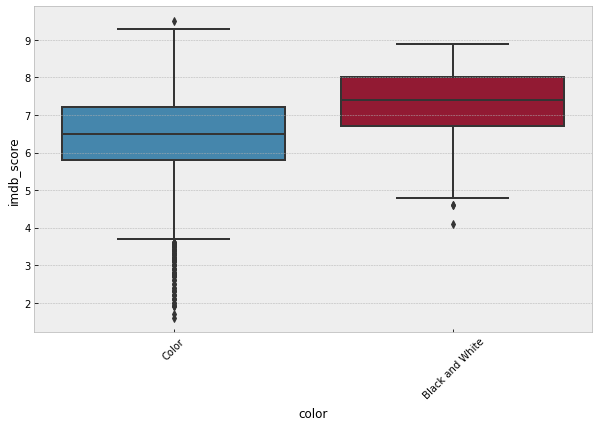

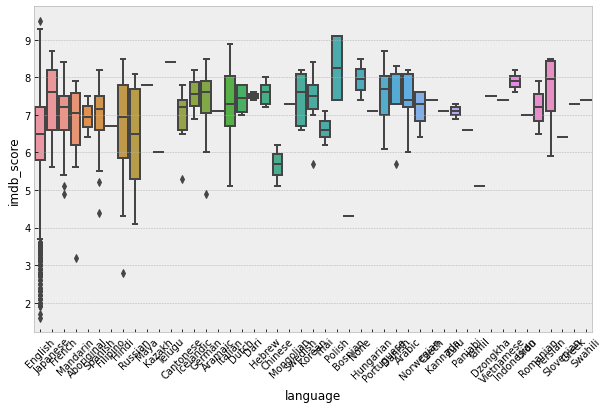

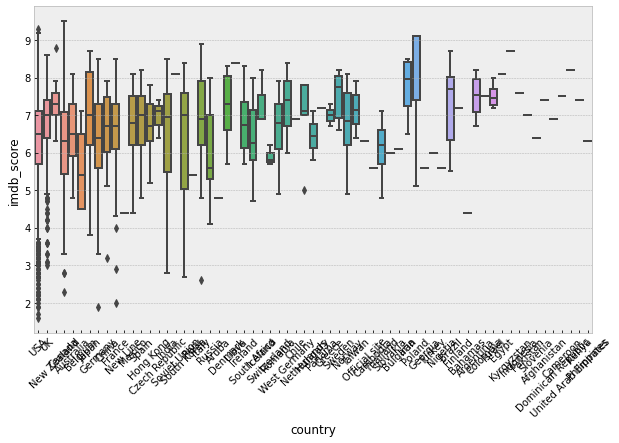

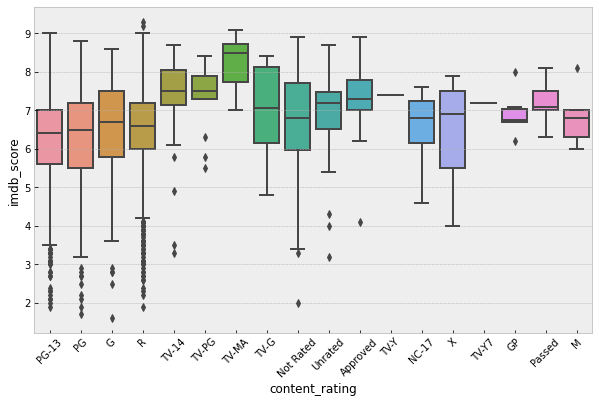

In [14]:
important_categorical = ['color', 'language', 'country', 'content_rating']

# Plotting boxplots for a few of these categorical features
imdb_score = df.select_dtypes(exclude = ['object'])['imdb_score']

df_categorical = pd.concat([features, imdb_score], axis=1, sort=False, copy=False)

for col in important_categorical:
    plt.figure(figsize = (10, 6))
    sns.boxplot(data=df_categorical, x=col, y='imdb_score')
    plt.xticks(rotation=45)
    plt.show()

We notice from above box plots that each category in these variables have a different distribution of `imdb_score`

Hence, adding these categorical variables in encoded form should help us improve the model

Below we see the frequency distribution of the categories in each of these categorical variables

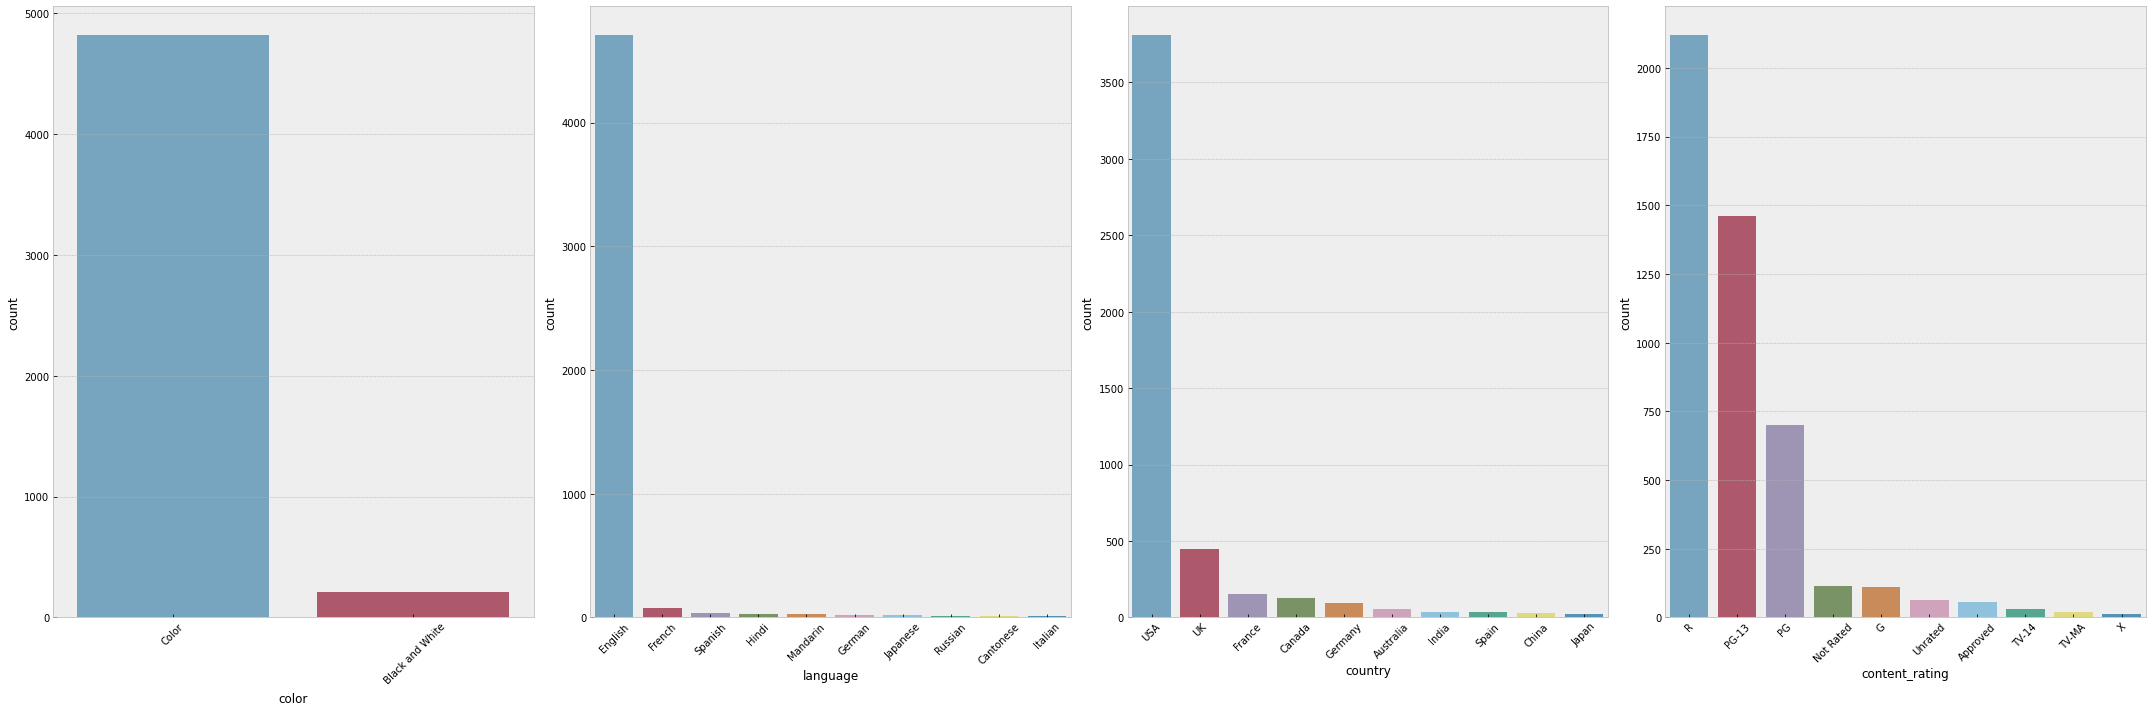

In [15]:
df_categorical = df[important_categorical]

# Frequency distribution of important categorical features
fig, axes = plt.subplots(round(len(df_categorical.columns) / 4), 4, figsize=(30, 10))

for i, ax in enumerate(fig.axes):
    if i < len(df_categorical.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_categorical.columns[i], alpha=0.7, data=df_categorical, ax=ax,
                     order=pd.value_counts(df_categorical.iloc[:,i]).iloc[:10].index)

fig.tight_layout()

<h1>Cross validation pipeline</h1>
    
    Steps
    1. Takes modelObject, data frame with numerical and categorical features
    2. categorical feature/s which have to be encoded is also an input
    3. Splits the data frame 10-fold training and test dataset
    4. Calculate adjusted rsquared value for all 10 test sets
    5. Outputs a dataframe with statistical distribution of adjusted rsquared value from 10 testing folds
    6. Distribution metrics include mean, stddev, min, max, 25%, 50% etc.

In [16]:
#Take model parameters as input and output adjusted-rsquared results
def cv_results_encoding_columns(modelObject, df, feature, run_pca=False):
    X = df.fillna(0)
    y = df['imdb_score']

    X_numpy = X.to_numpy()
    y_numpy = y.to_numpy()

    adjr2_all_folds = list()

    kf = KFold(n_splits=10)
    
    for train_index, test_index in kf.split(X_numpy):
        #print("TRAIN:", train_index, "TEST:", test_index)
        train_X = copy.deepcopy(X.iloc[train_index]).reset_index(drop=True)
        test_X = copy.deepcopy(X.iloc[test_index]).reset_index(drop=True)
        
        imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        imput_features = ['gross', 'budget']
        train_X[imput_features] = imputer.fit_transform(train_X[imput_features])
        test_X[imput_features] = imputer.transform(test_X[imput_features])
        
        # Running PCA
        if run_pca:
            train_X, test_X = run_custom_pca(train_X, test_X)
        
        if (feature == ""):
            X_train = train_X.drop(['imdb_score'], axis=1)
            X_test = test_X.drop(['imdb_score'], axis=1)
        else:
            X_train, X_test = mean_encoding_columns(train_X, test_X, feature)
            X_train = X_train.fillna(0)
            X_test = X_test.fillna(0)
        
        y_train = copy.deepcopy(y.iloc[train_index]).reset_index(drop=True)
        y_test = copy.deepcopy(y.iloc[test_index]).reset_index(drop=True)
        
        modelObject.fit(X_train, y_train)

        y_pred = modelObject.predict(X_test)

        #Model Metric - Regression

        r2 = r2_score(y_test, y_pred)

        p = X.shape[1]
        n = len(y)

        adjr2 = 1-((1-r2)*(n-1)/(n-p-1))
        #print(r2)
        adjr2_all_folds.append(r2)
    
    return pd.DataFrame(adjr2_all_folds).describe()

<h1> Random Forest Regressor</h1>

<h2>Metric used - Adjusted R-Squared.</h2> 
<p>Because, IMDB score is a continous variable and hence we are using regression, both Linear and RandomForest.</p>

<p>Adjusted R-squared is chosen instead of R-squared, as it increases only if the new feature improves the model more than would be expected by chance. It decreases when a feature improves the model by less than expected by chance. R-sqaured keeps increasing with feature addition to the model.</p>

    Steps - Base model (only numerical features)
    
    1. Split the data in 10 folds
    
    2. Train on 9 and predict on 1 fold
    
    3. Calculate adjusted r-squared for each fold prediction using RF regression model
    
    4. Take average adjusted r-squared to evaluate the performance of the model
    
    5. Create a base RF regression model with all numeric features
    
<h3> Adjusted R-squared from this model will be used as a baseline score</h3>

In [17]:
#Cross validation pipleine - RF regression

numerical_features = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()
categorical_features = df.select_dtypes(include = ['object']).columns.tolist()

#title_year is actually a categorical variable
numerical_features.remove("title_year") 
numerical_features.remove('imdb_score')
categorical_features.append("title_year")

model_features = copy.deepcopy(numerical_features)
model_features.append('imdb_score')

model = RandomForestRegressor(max_features="sqrt", n_estimators=150, max_depth=15, random_state=0, oob_score=True)

cv_score = dict()



#With PCA
df_results = cv_results_encoding_columns(model, df[model_features], "", run_pca=True).reset_index()
print('Adjusted rsquared for RF regressor model with PCA - {}'.format(list(df_results[df_results['index'] == 'mean'].values)[0][1]))

#Without PCA
df_results = cv_results_encoding_columns(model, df[model_features], "").reset_index()
print('Adjusted rsquared for RF regressor model without PCA - {}'.format(list(df_results[df_results['index'] == 'mean'].values)[0][1]))
cv_score['all_numeric'] = list(df_results[df_results['index'] == 'mean'].values)[0][1]

cv_score



Adjusted rsquared for RF regressor model with PCA - 0.4450456183223759
Adjusted rsquared for RF regressor model without PCA - 0.46220037530432806


{'all_numeric': 0.46220037530432806}

We see that RFRegressor model without PCA on correlated numerical features performs better. 

This implies that removing correlation between features leads to loss of information.

So, we will use RFRegressor model without PCA in below steps

<h2>Adding categorical features one by one in the model </h2>

<p>We will add categorical features one by one in the model and measure the Adjusted r-squared with the baseline score</p>



I have used mean encoding because the number of categories in the features are large.
Thus, one-hot encoding will lead to higher dimensions

Label encoding will add a ranking to the categorical variables which are not inherently ordered.


    
    Steps
    
    1. Mean Encode one categorical column 
    
    2. Use the individual encoded column and numerical column as feature set
    
    2. Train on 9 and predict on 1 fold and repeat for all 10 folds

    3. Calculate adjusted r-squared for each fold prediction using RF regression model

    4. Take average adjusted r-squared to evaluate the performance of the model

In [18]:
for feature in categorical_features:
    if (feature == 'genres' or feature == 'plot_keywords'):
        model_features.append('movie_title')
    model_features.append(feature)
    
    df_results = cv_results_encoding_columns(model, df[model_features], feature).reset_index() #Not performing PCA
    cv_score[feature] = list(df_results[df_results['index'] == 'mean'].values)[0][1]
    model_features.remove(feature)
    if (feature == 'genres' or feature == 'plot_keywords'):
        model_features.remove('movie_title')
        
cv_score

{'all_numeric': 0.46220037530432806,
 'color': 0.46448783250567105,
 'director_name': -0.5101667094888257,
 'actor_2_name': -0.9693110131818321,
 'genres': 0.5310974007151028,
 'actor_1_name': -0.5347264322162218,
 'movie_title': -2.7653557895350884,
 'actor_3_name': -1.3353720667519182,
 'plot_keywords': 0.2594685873907959,
 'language': 0.4638253353580847,
 'country': 0.4652882465618863,
 'content_rating': 0.46784834525647767,
 'title_year': 0.4620399963397947}

<h4>We collect all those categorical features which showed an improvement by adding to the model</h4>

In [19]:
#Keep only those categorical features which show an imporvement from all_numeric model
base_line = cv_score['all_numeric']
extra_features = list()
for k,v in cv_score.items():
    if v > base_line:
        extra_features.append(k)


extra_features.remove('genres')
extra_features.append('genres') #because we need genres as a last value in the categorical encoding columns

extra_features

['color', 'language', 'country', 'content_rating', 'genres']

<h4> We create RF regressor model with 10-fold cross validation including all the numerical columns and the selected categorical columns from step above </h4>

<p>We take the average of the adjusted rsquared metric from the 10-folds as our final adjusted rsquared metric for this model</p>

In [20]:
#Cross validation pipleine - RF regressionn - 
#using categorical columns which showed a lift from only using numerical columns 

numerical_features = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()
categorical_features = df.select_dtypes(include = ['object']).columns.tolist()

#title_year is actually a categorical variable
numerical_features.remove("title_year") 
numerical_features.remove('imdb_score')
categorical_features.append("title_year")

model_features = copy.deepcopy(numerical_features)


model_features.append('imdb_score')

for features in extra_features:
    model_features.append(features)


#because we need genres as a last value in the categorical encoding columns list
#since we use the movie_title column also while encoding this

model_features.append('movie_title') # this is needed for mean ecoding complex columns.


model = RandomForestRegressor(max_features="sqrt", n_estimators=150, max_depth=15, random_state=0, oob_score=True)

# With PCA
df_results = cv_results_encoding_columns(model, df[model_features], extra_features, run_pca=True).reset_index()
print('Adjusted rsquared for RF regressor model with PCA on correlated numerical features and including encoded categorical columns from above step - {}'.format(list(df_results[df_results['index'] == 'mean'].values)[0][1]))

# Without PCA
df_results = cv_results_encoding_columns(model, df[model_features], extra_features).reset_index()
print('Adjusted rsquared for RF regressor model without PCA on correlated numerical features and including encoded categorical columns from above step - {}'.format(list(df_results[df_results['index'] == 'mean'].values)[0][1]))

Adjusted rsquared for RF regressor model with PCA on correlated numerical features and including encoded categorical columns from above step - 0.5306645485697221
Adjusted rsquared for RF regressor model without PCA on correlated numerical features and including encoded categorical columns from above step - 0.5439087830262366


<h1>Linear Regression</h1>

<h2>Checking for multicollinearity for numerical features</h2>

Since we tried using PCA in the RFRegressor model above and it did not help. We will try VIF in the LinearRegression model to see if it improves the model
    
    Steps

    1. Calculate VIF of all features

    2. Drop the feature which has the highest VIF

    3. Repeat step 1

    4. Continue doing this untill VIF of all features are less than 5
    
We have two lists, one with all the numerical features and other with uncorrelated_numeric_features

In [21]:
#Handle multi collinearity
#Calculate VIF for feature space and subsequently drop features which have a VIF > 5
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

vif_max = 100
uncorrelated_numeric_features = copy.deepcopy(numerical_features)

while vif_max > 5:
    vif_df = calc_vif(df[uncorrelated_numeric_features].fillna(0))
    vif_max = vif_df['VIF'].max()
    correlated_feature = vif_df[vif_df['VIF']==vif_max]['variables'].tolist()[0]
    uncorrelated_numeric_features.remove(correlated_feature)
    
calc_vif(df[uncorrelated_numeric_features].fillna(0))

,variables,VIF
0,director_facebook_likes,1.128035
1,actor_3_facebook_likes,1.786856
2,actor_1_facebook_likes,1.402942
3,gross,2.290688
4,facenumber_in_poster,1.325435
5,num_user_for_reviews,2.406049
6,budget,1.048257
7,actor_2_facebook_likes,1.914759
8,aspect_ratio,1.617703
9,movie_facebook_likes,1.493937



<h2>Metric used - Adjusted R-Squared.</h2> 
<p>Because, IMDB score is a continous variable</p>

<p>Adjusted R-squared is chosen instead of R-squared, as it increases only if the new feature improves the model more than would be expected by chance. It decreases when a feature improves the model by less than expected by chance. R-sqaured keeps increasing with feature addition to the model.</p>


    Steps - Base model (only numerical features)
    
    1. Split the data in 10 folds
    
    2. Train on 9 and predict on 1 fold
    
    3. Calculate adjusted r-squared for each fold prediction using Linear regression model
    
    4. Take average adjusted r-squared to evaluate the performance of the model
    
    5. Create a base RF regression model with all numeric features
    
<h3> Adjusted R-squared from this model will be used as a baseline score</h3>

In [22]:
#Cross validation pipleine - Linear regression

numerical_features = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()
categorical_features = df.select_dtypes(include = ['object']).columns.tolist()

#title_year is actually a categorical variable
numerical_features.remove("title_year") 
numerical_features.remove('imdb_score')
categorical_features.append("title_year")
model = LinearRegression()


#Removing correlated features by using VIF
model_features = copy.deepcopy(uncorrelated_numeric_features)
model_features.append('imdb_score')

df_results = cv_results_encoding_columns(model, df[model_features], "").reset_index()
print('Adjusted rsquared for Linear regressor model using uncorrelated_numerical_columns - {}'.format(df_results[df_results['index'] == 'mean'].values[0][1]))


#Using all numerical features
model_features = copy.deepcopy(numerical_features)
model_features.append('imdb_score')

model = LinearRegression()
df_results = cv_results_encoding_columns(model, df[model_features], "").reset_index()
print('Adjusted rsquared for Linear regressor model using all numerical columns - {}'.format(df_results[df_results['index'] == 'mean'].values[0][1]))


cv_score = dict()
cv_score['all_numeric'] = df_results[df_results['index'] == 'mean'].values[0][1]
cv_score

Adjusted rsquared for Linear regressor model using uncorrelated_numerical_columns - 0.0870879640117268
Adjusted rsquared for Linear regressor model using all numerical columns - 0.20995009742021792


{'all_numeric': 0.20995009742021792}

<p>From the above step we see that the regression model performs better with all the numerical features as compared to using uncorrelated features </p>
<p> Hence we use all numerical features column for our further processing </p>

<h2>Add categorical features one by one in the model </h2>

<p>We will add categorical features one by one in the model and measure the Adjusted r-squared with the baseline score</p>



I have used mean encoding because the number of categories in the features are large

Thus, one-hot encoding will lead to higher dimesnions

Label encoding will add a ranking to the categorical variables which are not inherently ordered.


    
    Steps
    
    1. Mean Encode one categorical column 
    
    2. Use the one encoded column and numerical column as feature set
    
    2. Train on 9 and predict on 1 fold

    3. Calculate adjusted r-squared for each fold prediction using Linear regression model

    4. Take average adjusted r-squared to evaluate the performance of the model

In [23]:
for feature in categorical_features:
    if (feature == 'genres' or feature == 'plot_keywords'):
        model_features.append('movie_title')
    model_features.append(feature)
    
    df_results = cv_results_encoding_columns(model, df[model_features], feature).reset_index()
    cv_score[feature] = list(df_results[df_results['index'] == 'mean'].values)[0][1]
    model_features.remove(feature)
    if (feature == 'genres' or feature == 'plot_keywords'):
        model_features.remove('movie_title')

cv_score

{'all_numeric': 0.20995009742021792,
 'color': 0.22605625411458927,
 'director_name': -8.414254305042839,
 'actor_2_name': -12.132498192819076,
 'genres': 0.32461055654139476,
 'actor_1_name': -7.2684900060605155,
 'movie_title': -32.48219970934029,
 'actor_3_name': -16.05464633418121,
 'plot_keywords': -0.4993359397840603,
 'language': 0.021202799616046965,
 'country': 0.046799822432629236,
 'content_rating': 0.22963432905155967,
 'title_year': 0.09239248670451143}

<h4>We collect all those categorical features which showed an improvement by adding to the model</h4>

In [24]:
#Keep only those categorical features which show an imporvement from all_numeric model
base_line = cv_score['all_numeric']
extra_features = list()
for k,v in cv_score.items():
    if v > base_line:
        extra_features.append(k)

extra_features.remove('genres')
extra_features.append('genres') #because we need genres as a last value in the categorical encoding columns.

extra_features

['color', 'content_rating', 'genres']

<h2>Add categorical features one by one in the model </h2>

<p>We will add categorical features one by one in the model and measure the Adjusted r-squared with the baseline score</p>
    
    Steps
    
    1. Mean Encode one categorical column 
    
    2. Use the one encoded column and numerical column as feature set
    
    2. Train on 9 and predict on 1 fold

    3. Calculate adjusted r-squared for each fold prediction using RF regression model

    4. Take average adjusted r-squared to evaluate the performance of the model

In [25]:
#Cross validation pipleine - RF regressionn - 
#using categorical columns which showed a lift from only using numerical columns 

numerical_features = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()
categorical_features = df.select_dtypes(include = ['object']).columns.tolist()

#title_year is actually a categorical variable
numerical_features.remove("title_year") 
numerical_features.remove('imdb_score')
categorical_features.append("title_year")

model = LinearRegression()

# With PCA
model_features = copy.deepcopy(numerical_features)

model_features.append('imdb_score')
for features in extra_features:
    model_features.append(features)
model_features.append('movie_title')


df_results = cv_results_encoding_columns(model, df[model_features], extra_features).reset_index()
print('Adjusted rsquared for Linear regressor model with all numerical features and encoded categorical features - {}'.format(list(df_results[df_results['index'] == 'mean'].values)[0][1]))

# Without PCA
model_features = copy.deepcopy(uncorrelated_numeric_features)

model_features.append('imdb_score')
for features in extra_features:
    model_features.append(features)
model_features.append('movie_title')
df_results = cv_results_encoding_columns(model, df[model_features], extra_features).reset_index()
print('Adjusted rsquared for Linear regressor model with only uncorrelated_numerical_features and encoded categorical features - {}'.format(list(df_results[df_results['index'] == 'mean'].values)[0][1]))

Adjusted rsquared for Linear regressor model with all numerical features and encoded categorical features - 0.3483183651724194
Adjusted rsquared for Linear regressor model with only uncorrelated_numerical_features and encoded categorical features - 0.25469611486854615


<h1>Conclusion</h1>
<p> We tried 4 models as mentioned below - (all of these models include the of important categorical features in encoded form)</p>
    
    1. RFRegression without PCA on correlated numeric features - 0.5439
    2. RFRegression with PCA on correlated numeric features - 0.5306
    3. LinearRegression with all numeric features - 0.3483
    4. LInearRegression with uncorrelated numeric features - 0.2546

<p>Hence the <u>RFRegression without PCA</u> performs best. Maybe because of following reasons</p>

1. `imdb_score` doesn't show a linear correlation with features in the EDA section above - <b>Thus RF performs better than Linear model</b>

2. Number of features are low and even the correlation between them is not high - <b>Thus variable reduction leads to loss of information</b>


We used all the numerical columns and the below categorical columns to build the final RF regression model

    1. color
    2. language
    3. country
    4. content_rating
    5. genres
    
<h3> Adjusted Rsquared from the RFRegression without PCA is 0.5306 </h3>

This means that the RFRegression without PCA, is able to explian 53.06% variance in the `imdb_score` as compared to 34.83% by the best linear regression model.
    